/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


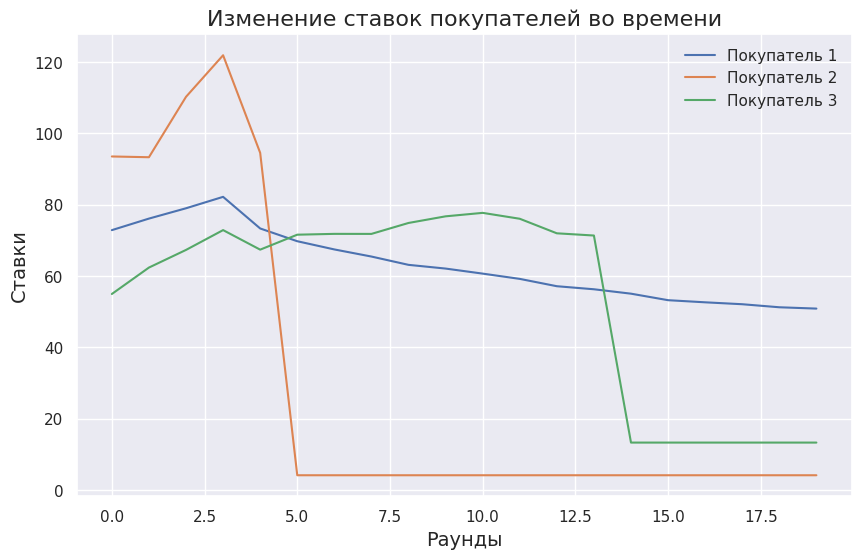

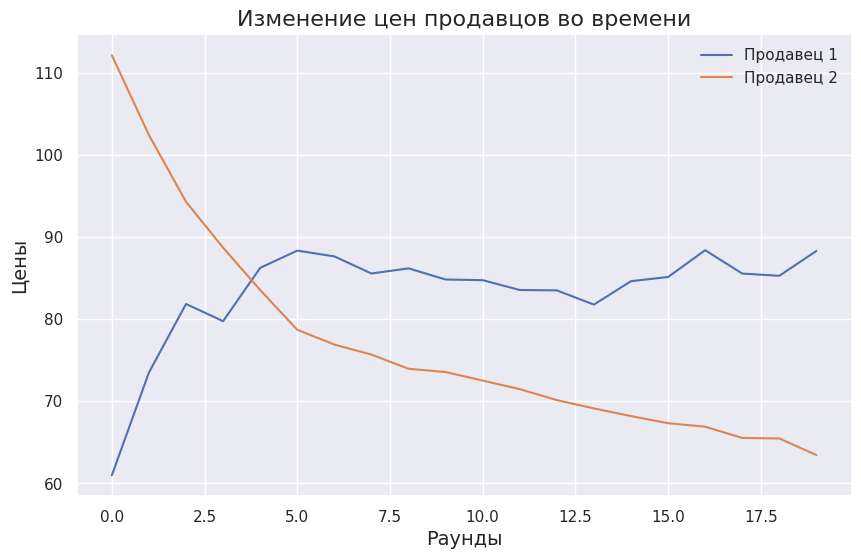

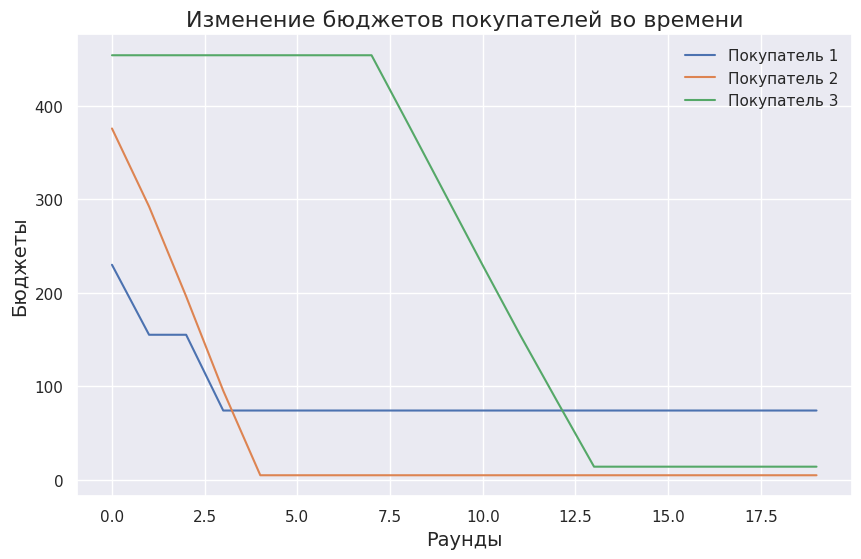

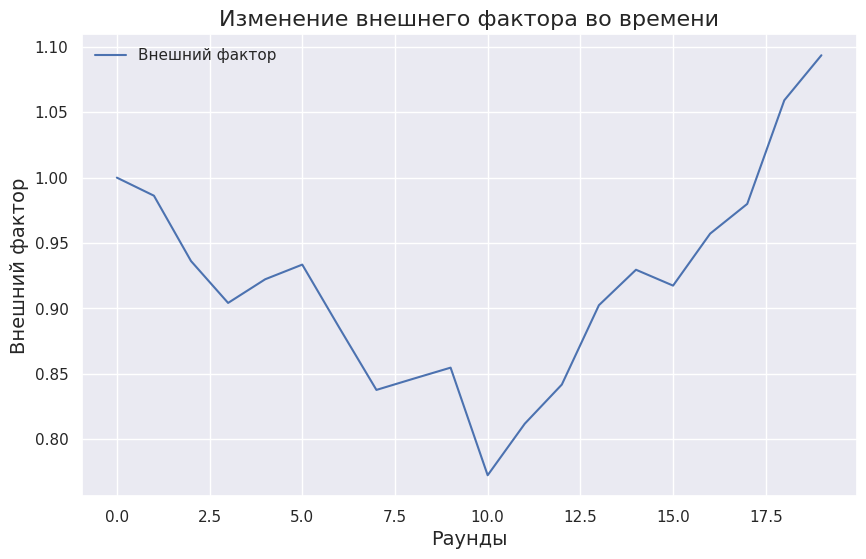

In [8]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Параметры игры
num_buyers = 3
num_sellers = 2
num_rounds = 20

# Инициализация начальных цен продавцов и начальных ставок покупателей
initial_prices = [random.randint(50, 150) for _ in range(num_sellers)]
initial_bids = [random.randint(30, 100) for _ in range(num_buyers)]

# Определение лимитов ставок и цен для каждого участника
buyer_limits = [random.randint(100, 200) for _ in range(num_buyers)]
buyer_budgets = [random.randint(200, 500) for _ in range(num_buyers)]
seller_costs = [random.randint(20, 80) for _ in range(num_sellers)]

# Коэффициенты адаптации
adaptation_rate = 0.1
external_factor_index = 1.0

# Определение стратегий участников
buyer_strategies = ["conservative", "aggressive", "adaptive"]
seller_strategies = ["aggressive", "adaptive"]

# Функции обновления стратегий и работы с рынком
def update_strategy(current, target, rate):
    return current + rate * (target - current)

def adjust_rate_based_on_market(demand, supply):
    if demand > supply:
        return adaptation_rate * 1.5
    elif demand < supply:
        return adaptation_rate * 0.75
    return adaptation_rate

def get_adaptation_rate(strategy, base_rate):
    if strategy == "conservative":
        return base_rate * 0.5
    elif strategy == "aggressive":
        return base_rate * 1.5
    elif strategy == "adaptive":
        return base_rate
    return base_rate

# Q-Learning модель
def create_q_model(input_shape, action_space):
    model = Sequential()
    model.add(Dense(24, input_dim=input_shape, activation="relu"))
    model.add(Dense(24, activation="relu"))
    model.add(Dense(action_space, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.01))
    return model

# Параметры Q-learning
state_size = 3
action_size = 5
q_model = create_q_model(state_size, action_size)

# Данные для визуализации
price_history = []
bid_history = []
budget_history = []
external_factor_history = []

buyer_bids = initial_bids[:]
seller_prices = initial_prices[:]

for round_num in range(1, num_rounds + 1):
    total_demand = sum(buyer_bids) * external_factor_index
    total_supply = sum(seller_prices) * external_factor_index
    current_adaptation_rate = adjust_rate_based_on_market(total_demand, total_supply)

    # Покупатели делают ставки
    for i in range(num_buyers):
        if buyer_budgets[i] > 0:
            individual_rate = get_adaptation_rate(buyer_strategies[i], current_adaptation_rate)
            upper_limit = max(30, int(min(buyer_limits[i], buyer_budgets[i])))
            target_bid = random.randint(30, upper_limit)
            buyer_bids[i] = update_strategy(buyer_bids[i], target_bid, individual_rate)
            buyer_bids[i] = min(buyer_bids[i], buyer_limits[i], buyer_budgets[i])
            state = np.array([seller_prices[i % num_sellers], buyer_bids[i], external_factor_index])
            action = np.argmax(q_model.predict(state.reshape(1, -1), verbose=0))
            buyer_bids[i] += action - 2

    # Продавцы устанавливают цены
    for i in range(num_sellers):
        individual_rate = get_adaptation_rate(seller_strategies[i], current_adaptation_rate)
        target_price = random.randint(seller_costs[i] + 10, seller_costs[i] * 2)
        seller_prices[i] = update_strategy(seller_prices[i], target_price, individual_rate)
        seller_prices[i] = max(seller_prices[i], seller_costs[i])
        state = np.array([seller_prices[i], buyer_bids[i % num_buyers], external_factor_index])
        action = np.argmax(q_model.predict(state.reshape(1, -1), verbose=0))
        seller_prices[i] += action - 2

    transactions = []
    for buyer_index, bid in enumerate(buyer_bids):
        for seller_index, price in enumerate(seller_prices):
            if bid >= price:
                negotiated_price = (bid + price) / 2
                if buyer_budgets[buyer_index] >= negotiated_price:
                    transactions.append((buyer_index, seller_index, negotiated_price))
                    buyer_budgets[buyer_index] -= negotiated_price
                    break

    # Сохраняем данные для визуализации
    price_history.append(seller_prices[:])
    bid_history.append(buyer_bids[:])
    budget_history.append(buyer_budgets[:])
    external_factor_history.append(external_factor_index)

    external_factor_index = external_factor_index * random.uniform(0.9, 1.1)

# Преобразование данных для визуализации
price_history = np.array(price_history)
bid_history = np.array(bid_history)
budget_history = np.array(budget_history)
external_factor_history = np.array(external_factor_history)

# Визуализация с использованием Seaborn
sns.set(style="darkgrid")

# График изменения ставок покупателей
plt.figure(figsize=(10, 6))
for i in range(num_buyers):
    sns.lineplot(x=np.arange(num_rounds), y=bid_history[:, i], label=f'Покупатель {i + 1}')
plt.title('Изменение ставок покупателей во времени', fontsize=16)
plt.xlabel('Раунды', fontsize=14)
plt.ylabel('Ставки', fontsize=14)
plt.legend()
plt.show()

# График изменения цен продавцов
plt.figure(figsize=(10, 6))
for i in range(num_sellers):
    sns.lineplot(x=np.arange(num_rounds), y=price_history[:, i], label=f'Продавец {i + 1}')
plt.title('Изменение цен продавцов во времени', fontsize=16)
plt.xlabel('Раунды', fontsize=14)
plt.ylabel('Цены', fontsize=14)
plt.legend()
plt.show()

# График изменения бюджетов покупателей
plt.figure(figsize=(10, 6))
for i in range(num_buyers):
    sns.lineplot(x=np.arange(num_rounds), y=budget_history[:, i], label=f'Покупатель {i + 1}')
plt.title('Изменение бюджетов покупателей во времени', fontsize=16)
plt.xlabel('Раунды', fontsize=14)
plt.ylabel('Бюджеты', fontsize=14)
plt.legend()
plt.show()

# График изменения внешнего фактора
plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(num_rounds), y=external_factor_history, label='Внешний фактор')
plt.title('Изменение внешнего фактора во времени', fontsize=16)
plt.xlabel('Раунды', fontsize=14)
plt.ylabel('Внешний фактор', fontsize=14)
plt.legend()
plt.show()
